In [1]:
%reload_ext autoreload
%autoreload 2

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.path.append('../../')

import funcs 
import load_data
import numpy as np
import pandas as pd
from tqdm import tqdm
import subprocess
from time import time
import git
import matplotlib.pyplot as plt
from scipy.special import bdtrc
import warnings
import ipywidgets
warnings.filterwarnings('ignore')

%reload_ext load_data
%reload_ext funcs

2021-12-11 10:29:55.649790: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-11 10:30:03.828710: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-11 10:30:03.829920: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-11 10:30:03.829952: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-11 10:30:03.829987: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sdmz-dtn-4.hpc.arizona.edu): /proc/driver/nvidia/version does not exist
2021-12-11 10:30:03.830390: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

# <span style="color:white; opacity:0.7; font-family:PT Sans Narrow; font-size:1.3em"> 1. Loading the Data </span>
## <span style="color:green; font-family:PT Sans Narrow; font-size:1.1em"> 1.1 Selecting the Dataset </span>

In [5]:
dataset = ipywidgets.Dropdown( options = [ ('1. kr-vs-kp'    ,'kr-vs-kp'), 
                                           ('2. mushroom'    ,'mushroom'),
                                           ('3. sick'        ,'sick'),
                                           ('4. spambase'    ,'spambase'),
                                           ('5. tic-tac-toe' ,'tic-tac-toe'),
                                           ('6. splice'      ,'splice'),
                                           ('8. waveform'    ,'waveform'),
                                           ('9. biodeg'      ,'biodeg'),
                                           ('10. horse-colic','horse-colic'),
                                           ('11. ionosphere' ,'ionosphere'),
                                           ('12. vote'       ,'vote')],      
                                value = 'ionosphere')


@ipywidgets.interact(WHICH_DATASET = dataset)
def read_data(WHICH_DATASET):
    if WHICH_DATASET in ['sick','splice','biodeg','vote','horse-colic']:
        print('dataset does not exist')

    else:
        data, feature_columns = load_data.aim1_3_read_download_UCI_database(WHICH_DATASET=WHICH_DATASET, mode='read')
        print(data['train'].head(3))
        print('train shape:',data['train'].shape)

interactive(children=(Dropdown(description='WHICH_DATASET', index=9, options=(('1. kr-vs-kp', 'kr-vs-kp'), ('2…

## <span style="color:Green; font-family:PT Sans Narrow; font-size:1.1em"> 1.2 Loading the Dataset </span>

In [17]:
data, feature_columns = load_data.aim1_3_read_download_UCI_database(WHICH_DATASET=dataset.value, mode='read')

----------   


In [19]:
data['train'].head(3)

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a25,a26,a27,a28,a29,a30,a31,a32,a33,true
1,1,0,1.0,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.1904,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.0,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.4310,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,0,1.0,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.0000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0


# <span style="color:white; opacity:0.8; font-family:PT Sans Narrow; font-size:1.3em"> 2.  Final evaluation results: Using just the measured weights </span>

Measuring accuracy for proposed techniques, Tao and MV for different number of workers over 20 simulations.

1. Applying aim1.3 proposed technique 
2. Measurinng weights for each worker for different experiements (noisy labels)
3. Measuring the benchmark (Tao) accuracy

---
number of simulations = 20
- These simulations are used to measure uncertianty. 
- All simulations are employed using the same noisy dataset. 
- The MV over the predicted labels for these 20 is used as the predicted label for proposed method

In [21]:

ARLS = {'num_labelers': 20, 
        'low_dis':      0.3, 
        'high_dis':     0.9}

predicted_labels, uncertainty, true_labels, labelers_strength = funcs.apply_technique_aim_1_3( data = data, ARLS = ARLS, num_simulations = 20,  feature_columns = feature_columns)

workers: 100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


In [ ]:
F, acc = {}, {}

for strategy in ['freq','beta']:
    acc[strategy] = pd.DataFrame(index=['method1','method2','Tao','Sheng', 'MV'],columns=[2])
    F[strategy]   = {}


for NL in range(2,40): # number of workers

    F_both, accuracy_both = funcs.aim1_3_full_accuracy_comparison(data=data, num_labelers=NL, num_simulations=20, feature_columns=feature_columns)

    for strategy in ['freq','beta']:
        acc[strategy][NL] = accuracy_both[strategy].T
        F[strategy][f'num_labelers_{NL}'] = F_both[strategy]

workers:  63%|██████▎   | 12/19 [00:03<00:01,  3.64it/s]


KeyboardInterrupt: 

In [ ]:
strategy = 'freq'
acc[strategy].round(decimals=2)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
method1,0.34,0.33,0.73,0.61,0.69,0.56,0.71,0.63,0.93,0.74,0.89,0.94,0.87,0.94,0.87,0.86,0.91
method2,0.30,0.33,0.26,0.61,0.53,0.56,0.69,0.63,0.91,0.84,0.89,0.96,0.89,0.97,0.90,0.93,0.93
Tao,0.34,0.33,0.61,0.61,0.51,0.56,0.56,0.63,0.80,0.74,0.84,0.94,0.87,0.91,0.83,0.86,0.89
Sheng,0.21,0.33,0.30,0.61,0.40,0.56,0.50,0.63,0.76,0.74,0.73,0.94,0.79,0.91,0.74,0.86,0.91
MV,0.43,0.69,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.79,0.77,0.77


## <span style="color:Green; opacity:0.8; font-family:PT Sans Narrow; font-size:1.1em"> 2.2 Renaming the files to final names </span>

In [ ]:
acc2 = acc.copy()
acc2['freq'] = acc2['freq'].rename({'method2':'uwMV-freq (proposed)' , 'Tao':'wMV-freq (Tao et al.)', 'Sheng':'MV-freq (Sheng et al.)'})
acc2['beta'] = acc2['beta'].rename({'method2':'uwMV-beta (proposed)' , 'Tao':'wMV-beta (Tao et al.)', 'Sheng':'MV-beta (Sheng et al.)'})

## <span style="color:Green; opacity:0.8 ; font-family:PT Sans Narrow; font-size:1.1em"> 2.3 plots </span>

### <span style="color:Orange; opacity:0.8; font-family:PT Sans Narrow; font-size:1.3em"> 2.3.1 mode: freq </span>

Text(0.5, 1.0, 'Dataset: ionosphere   -   technique: freq')

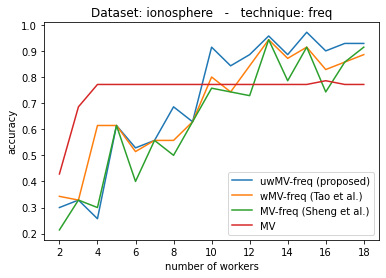

In [ ]:
strategy = 'freq'
acc2[strategy].drop(['method1']).T.plot()
plt.xlabel('number of workers')
plt.ylabel('accuracy')
plt.title('Dataset: ' + dataset.value + '   -   technique: ' + strategy)

### <span style="color:Orange; opacity:0.8;  font-family:PT Sans Narrow; font-size:1.3em"> 2.3.1 mode: beta </span>

Text(0.5, 1.0, 'Dataset: ionosphere   -   technique: beta')

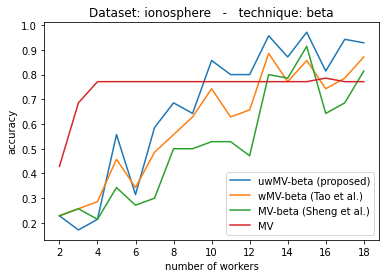

In [ ]:
strategy = 'beta'
acc2[strategy].drop(['method1']).T.plot()
plt.xlabel('number of workers')
plt.ylabel('accuracy')
plt.title('Dataset: ' + dataset.value + '   -   technique: ' + strategy)

### <span style="color:Orange; opacity:0.8;  font-family:PT Sans Narrow; font-size:1.3em"> 2.3.3 freq vs beta for the proposed technique </span>

Text(0.5, 1.0, 'Dataset: ionosphere')

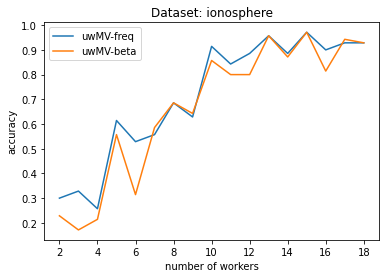

In [ ]:
acc_freq_vs_beta = pd.DataFrame()
acc_freq_vs_beta['uwMV-freq'] = acc['freq'].T['method2']
acc_freq_vs_beta['uwMV-beta'] = acc['beta'].T['method2']

acc_freq_vs_beta.plot()
plt.xlabel('number of workers')
plt.ylabel('accuracy')
plt.title('Dataset: ' + dataset.value)

# <span style="color:red; opacity:0.8;  font-family:PT Sans Narrow; font-size:1.3em"> ** BELOW CAN BE IGNORED ** </span>

# <span style="color:white; opacity:0.8;  font-family:PT Sans Narrow; font-size:1.3em"> 3. Repeating prior experiment for only 20 workers => to measure confidence score </span>

## <span style="color:Green; opacity:0.8;  font-family:PT Sans Narrow; font-size:1.1em"> 3.1 Measuring prob/uncertainties </span>

In [ ]:
ARLS = {'num_labelers': 10, 
        'low_dis':      0.3, 
        'high_dis':     0.9}
    
predicted_labels, uncertainty, true_labels, labelers_strength = funcs.apply_technique_aim_1_3( data = data,
                                                                                        ARLS = ARLS,
                                                                                        num_simulations = 20, 
                                                                                        feature_columns = feature_columns)

labels_all_workers         = predicted_labels['test']['mv'] 
uncertainty_all_workers    = uncertainty['test']
truth                      = true_labels['test'].truth

uncertainty['test'].head(3).append(labelers_strength.T).round(decimals=3)                                                                                        

workers: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


,labeler_0,labeler_1,labeler_2,labeler_3,labeler_4,labeler_5,labeler_6,labeler_7,labeler_8,labeler_9
18,0.498,0.402,0.498,0.000,0.507,0.463,0.463,0.483,0.000,0.301
21,0.463,0.301,0.512,0.402,0.498,0.359,0.436,0.483,0.463,0.359
23,0.512,0.218,0.402,0.483,0.359,0.463,0.402,0.301,0.436,0.301
labelers_strength,0.408,0.312,0.578,0.735,0.552,0.591,0.308,0.592,0.865,0.810
accuracy-test,0.371,0.186,0.686,0.857,0.543,0.643,0.114,0.571,0.929,0.914


## <span style="color:Green; opacity:0.8 ; font-family:PT Sans Narrow; font-size:1.1em"> 3.2 Measuring weights for each labeler </span>

***
### <span style="color:Orange; opacity:0.8 ;  font-family:PT Sans narrow; font-size:1.1em"> 3.2.1 First Method: </span>

$ T_{x,a,j} = 1 - u_{j} $

***
### <span style="color:Orange; opacity:0.8 ;  font-family:PT Sans narrow; font-size:1.1em"> 3.2.2 Second Method: </span>

$ T_{x,a,j} = \left\{
    \begin{array} \\
        1 - u_{j} & y_{a,j} = y'_{j}   \\
        0 & y_{a,j} \neq y'_{j}
    \end{array}
\right. $
***

### <span style="color:Orange; opacity:0.8 ;  font-family:PT Sans narrow; font-size:1.1em"> 3.2.3 Measuring average weight </span>

$ \hat{w}_{a,j} = \frac {1}{N} \sum_{x} T_{x,a,j}$

$ w_{a,j} = \frac {\hat{w}_{a,j}} {\sum_{a=1}^{L} \hat{w}_{a,j}} $

***
## <span style="color:Green; opacity:0.8 ;  font-family:PT Sans Narrow; font-size:1.1em"> 3.3 Weighted majority voting </span>


### <span style="color:Orange; opacity:0.8 ;  font-family:PT Sans narrow; font-size:1.1em"> 3.3.1 Applying the weights to predicted probabilities </span>

$ \hat{p}^{prob}_{j} = \sum_{a=1}^{L} p_{a,j} * w_{a,j} $

### <span style="color:Orange; opacity:0.8 ;  font-family:PT Sans narrow; font-size:1.1em"> 3.3.2 Applying the weights to predicted labels </span>

$ \hat{p}^{binary}_{j} = \sum_{a=1}^{L} y_{a,j} * w_{a,j}$ where $y_{a,j} = (p_{a,j} > 0.5) $
***

In [ ]:
weights, prob_weighted = funcs.aim1_3_measuring_weights( labels_all_workers=labels_all_workers, 
                                                    uncertainty_all_workers=uncertainty_all_workers)

### <span style="color:Orange; font-family:PT Sans narrow; font-size:1.3em"> 3.3.3 Measuring the weighted MV using only the measured weights (without confidence scores) </span>

In [ ]:
# measuring the new accuracies
acc2 = ( (prob_weighted > 0.5).T == truth ).mean(axis=1)
acc2['num_labelers'] = ARLS['num_labelers']

accuracy2 = pd.DataFrame( {'accuracy': acc2}).T.set_index('num_labelers')

accuracy2

,method1,method2
num_labelers,,
10.0,0.8,0.8


In [ ]:
F, acc = funcs.aim1_3_measure_confidense_score(delta=labels_all_workers, weights=weights, conf_score_strategy=1, num_labelers=ARLS['num_labelers'], truth=true_labels['test'].truth)

acc

TypeError: aim1_3_measure_confidense_score() got an unexpected keyword argument 'conf_score_strategy'

In [ ]:
# acc2 = ((F1.method1>0.5) == (truth > 0.5) ).mean(axis=0)
# acc2
# truth
# F1.method1>0.5
F1

,method1,method2
9,0.619439,0.799819
20,0.619439,0.799819
21,0.615834,0.779053
23,0.701288,0.884796
26,0.701288,0.884796
...,...,...
3169,0.514359,0.600340
3187,0.701288,0.884796
3189,0.807642,0.919754
3193,0.560326,0.561939


# <span style="color:white; opacity:0.8; font-family:PT Sans Narrow; font-size:1.3em"> 4. Benchmark </span>

## <span style="color:Green; opacity:0.8; font-family:PT Sans Narrow; font-size:1.1em"> 4.1 Overall quality of different workers </span>


Estimating the overall qualities of different workers is not a new research topic in the crowdsourcing learning community. To the best of the authors’ knowledge, there exist many state-of-the-art algorithms, such as Dawid–Skene [1], ZenCrowd , KOS [9], and DEW [15, 23]. However, none of them exploit feature vectors of instances, which makes it impossible to take full advantage of the statistical characteristics of the available data when evaluating the label qualities. According to the observation by [30], in traditional supervised learning, there exists a schema to exhibit the relationship between data features and the ground-truth labels. For example, suppose there exists a high-quality worker; the data schema will be well-inherited in their labels, because the difference between their labels and ground-truth labels is small. Meanwhile, suppose there exists a low-quality worker, the data schema may be broken because their labels will be very different from the ground-truth labels. Therefore, we can estimate the overall quality of a worker by evaluating how well the schema is inherited in their labels. Specifically, we can first extract all training instances’ feature vectors and the corresponding crowd labels provided by the jth worker to form a new single-label data set. Then, we use tenfold cross-validation to evaluate the classification accuracy of a classifier. In theory, this classifier can be any classifier. Finally, we define the overall quality of the jth worker as the classification accuracy of the built classifier. The detailed formula can be expressed as


$ \tau_{a} = \frac {\sum_{i=1}^{n} \delta \Big( f_{a}(x_{i}) , I_{i,a}  \Big)}{n} $

where n is the size of the extracted data set and $f_{j}(x_{i})$ is the class label of the feature vector $x_{i}$ predicted by the built classifier.

***

## <span style="color:Green; opacity:0.8; font-family:PT Sans Narrow; font-size:1.1em"> 4.2 Specific quality of the $j_{th}$ worker for the $i_{th}$ instance ($s_{ij}$) </span>

$ s_{x,a} = \sum^{a'=L}_{ (a'=1) \land (a' \neq a) } \delta \Big( l_{x,a},l_{x,a'} \Big) $

***
$ \gamma_{x,a} =\tau_{x,a}(1 + s_{x,a}^{2}) $

***
$ w'_{x,a} = \frac {1} {1 + e^{-\gamma_{x,a}} } $

***
$ Z = \frac {1}{L} \sum_{a=1}^{L}w'_{x,a}  $

‍‍‍``` Z is a normalization constant, which ensures that the sum of all crowd label weights for the ith instance is still equal to m ```

***
$ w_{x,j} = \frac {1}{Z} w'_{x,j}  $

In [ ]:
labels = funcs.aim1_3_measuring_benchmark_accuracy(delta=predicted_labels['test']['simulation_0'] , true_labels=true_labels['test'].drop(columns=['truth']))

# measuring accuracy
accuracy2['WMV_Tao'] = ( labels['WMV_Tao'] == true_labels['test'].truth ).mean(axis=0)
accuracy2['MV']      = ( labels['MV']      == true_labels['test'].truth ).mean(axis=0)

accuracy2

,method1,method2,WMV_Tao,MV
num_labelers,,,,
10.0,0.910798,0.956182,0.849765,0.798122


# <span style="color:white; opacity:0.8; font-family:PT Sans Narrow; font-size:1.3em"> 5. Confidense score: _Weighted-soft-MV_ </span>

## <span style="color:Green; opacity:0.8; font-family:PT Sans Narrow; font-size:1.1em"> 5.1 Measuring the certainty score of majority class $ P_{x,j} $ </span>


In actual formula this is divided by weights.sum(axis=1). But because weights sum to 1, its values would be 1.

Also pandas automatically transfers the binary values in delta\[disease\] to float before doing the multiplication.

where $\delta(y_{a,j},+)$ is $1$ if $y_{a,j}$ is positive (TRUE) otherwise $0$. $\delta(y_{a,j},-)$ is $1$ if $y_{a,j}$ is negative (FALSE) otherwise $0$

$ P_{x,j} = \frac { \sum_{a=1}^{L} {ω_{a,j} δ(y_{a,j},+)} } { \sum_{a=1}^{L} {ω_{a,j} δ(y_{a,j},+)}  +  \sum_{a=1}^{L} {ω_{a,j} δ(y_{a,j},-)} }$

***
## <span style="color:Green; opacity:0.8; font-family:PT Sans Narrow; font-size:1.1em"> 5.2 Certainty of majority class for both positive & negative labels </span>

$F_{x,j} = max \Big(P_{x,j} , 1-P_{x,j} \Big)$

In [ ]:
F1 = funcs.aim1_3_measure_confidense_score(delta=labels_all_workers, weights=weights, conf_score_strategy=1, num_labelers=ARLS['num_labelers'], truth=true_labels['test'].truth)
F1

,method1,method2
9,0.619439,0.799819
20,0.619439,0.799819
21,0.615834,0.779053
23,0.701288,0.884796
26,0.701288,0.884796
...,...,...
3169,0.514359,0.600340
3187,0.701288,0.884796
3189,0.807642,0.919754
3193,0.560326,0.561939


***
# <span style="color:white; font-family:PT Sans Narrow; font-size:1.3em"> 6. Confidense score: _Beta-soft-MV_ </span>

> Note: _This is measured only for METHOD1 since it has a higher accuracy_

## <span style="color:Green; font-family:PT Sans Narrow; font-size:1.1em"> 6.1 Measuring the certainty score of majority class  $f_{x,j}^{-+}$ </span>



$f^{+}_{x,j}≔1+\sum_{a=1}^{L}ω_{a,j}  \delta \big( y_{a,j},+ \big) $

$f_{x,j}^{-}≔1+\sum_{a=1}^{L}ω_{a,j}  \delta \big( y_{a,j},- \big) $

***
## <span style="color:Green; font-family:PT Sans Narrow; font-size:1.1em"> 6.2 Measuring the regularized incomplete beta function </span>


$I_{x} (α,β)=F(x;α,β)=\frac{ B(x;α,β) }{B(α,β)} $

$ bdtrc(k,n,p) = I_{p} \Big( \lfloor {k} \rfloor + 1 , n - \lfloor {k} \rfloor \Big) = \sum_{j = \lfloor {k} \rfloor + 1} ^ {n} \binom {n}{j}p^{j}(1-p)^{n-j} $

> [source](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.bdtrc.html)


## <span style="color:Green; font-family:PT Sans Narrow; font-size:1.1em"> 6.3 Certainty of majority class for both positive & negative labels </span>

$F_{x,j} = max(I_{p} , 1-I_{p})$

In [ ]:
F2 = funcs.aim1_3_measure_confidense_score(delta=labels_all_workers, weights=weights, method=2, num_labelers=ARLS['num_labelers'], truth=true_labels['test'].truth)
F2

,method1,method2
9,0.937500,0.964844
20,0.937500,0.964844
21,0.937500,0.964844
23,0.964844,0.980469
26,0.964844,0.980469
...,...,...
3169,1.000000,1.000000
3187,1.000000,1.000000
3189,1.000000,1.000000
3193,1.000000,1.000000
